# scNT-seq human hematopoiesis dynamics

In this tutorial, we will demonstrate how to perform absolute total RNA velocity analyses with the metabolic labeling datasets that was reported in the dynamo Cell paper. This notebook reproduces the total RNA velocity analyses reported in figure 3B of the original cell study. Note that dynamo is equiped with the processed hematopoiesis dataset produced following the steps presented in this notebook. You can download the processed data via ``dyn.sample_data.hematopoiesis``.


In [1]:
%%capture

import dynamo as dyn
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

First let us download the raw hematopoiesis data via ``dyn.sample_data.hematopoiesis_raw``. The`new` and `total` layers correspond to the labeled RNA and total RNA and will be used for total RNA velocity analyses estimation. Note that in order to ensure the reproducibility, we will also included the umap embedding in `.obsm['X_umap']` generated previously. 

In [2]:
adata_hsc_raw = dyn.sample_data.hematopoiesis_raw()
adata_hsc_raw


AnnData object with n_obs × n_vars = 1947 × 26193
    obs: 'batch', 'cell_type', 'time'
    var: 'gene_name_mapping'
    uns: 'genes_to_use'
    obsm: 'X_umap'
    layers: 'new', 'spliced', 'total', 'unspliced'

We use the monocle recipe to preprocess the `adata` object. Importantly, to ensure the reproducibility, we also use a predefined gene list that includes the highly variable genes and known markers genes based on previous reports ([Paul, cell, 2015](https://pubmed.ncbi.nlm.nih.gov/26627738/), [Weintrab, Science, 2020](https://pubmed.ncbi.nlm.nih.gov/31974159/), etc). The gene list is stored in `adata_hsc_raw.uns["genes_to_use"]` of the hematopoiesis raw dataset came with dynamo. 

Note that the `time` key indicates the RNA metabolic labeling duration. Since we labeled cells from the same harvest time point for a single time pulse, so the experiment_type is set to be "one-shot" (although we labeled cells at day 7 for 3 hours while cells at day 10 for 5 hours). 

In [3]:
selected_genes_to_use = adata_hsc_raw.uns["genes_to_use"]

In [4]:
preprocessor = dyn.pp.Preprocessor(force_gene_list=selected_genes_to_use)
preprocessor.config_monocle_recipe(adata_hsc_raw, n_top_genes=len(selected_genes_to_use))   
preprocessor.filter_cells_by_outliers_kwargs["keep_filtered"] = True
preprocessor.preprocess_adata_monocle(
    adata_hsc_raw,
    tkey="time",
    experiment_type="one-shot",
)

|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.


INFO:biothings.client:[ Future queries will be cached in "/Users/xiaojieqiu/PycharmProjects/dynamo_local/pr_version/dynamo-release/debug/mygene_cache.sqlite" ]
INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-3000...
INFO:biothings.client:done.
INFO:biothings.client:querying 3001-4000...
INFO:biothings.client:done.
INFO:biothings.client:querying 4001-5000...
INFO:biothings.client:done.
INFO:biothings.client:querying 5001-6000...
INFO:biothings.client:done.
INFO:biothings.client:querying 6001-7000...
INFO:biothings.client:done.
INFO:biothings.client:querying 7001-8000...
INFO:biothings.client:done.
INFO:biothings.client:querying 8001-9000...
INFO:biothings.client:done.
INFO:biothings.client:querying 9001-10000...
INFO:biothings.client:done.
INFO:biothings.client:querying 10001-11000...
INFO:biothings.client:done.
INFO:biothings.client:querying 11001-12000...
IN

|-----> [Preprocessor-monocle] completed [52.9206s]


In [5]:
adata_hsc_raw.var.use_for_pca.sum()

1754

In [6]:
dyn.tl.reduceDimension(adata_hsc_raw)

|-----> retrieve data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> [UMAP] completed [0.1044s]


## Estimate RNA velocity with the Model 2

In general, dynamo supports two major models for estimating kinetic parameters and RNA velocity for tscRNA-seq data. The Model 2 doesn't consider RNA splicing while Monocle 3 does (see Fig. SI2. A).

Note that we also use labeling time to group cells for gene expression smoothing via `dyn.tl.moments`. 

In [7]:
dyn.tl.moments(adata_hsc_raw, group="time")

|-----> calculating first/second moments...
|-----> [moments calculation] completed [11.4238s]


Since we actually have unsplicing/splicing data in our adata, dynamo's preprocess module automatically recognizes this and then tag the `adata` to have both splicing and labeling information. In order to use Model 2, here we purposely set `has_splicing` to be false, which then considers labeling data (new/total) while ignores unsplicing/splicing information.

Note that in order to ensure the reproducibility, we set `one_shot_method="sci_fate", model="deterministic"` but running with default parameters will give you very similar results. 

In [8]:
adata_hsc_raw.uns["pp"]["has_splicing"] = False
dyn.tl.dynamics(adata_hsc_raw, group="time", one_shot_method="sci_fate", model="deterministic");


|-----> calculating first/second moments...
|-----> [moments calculation] completed [2.6312s]


estimating alpha: 100%|██████████████████| 1754/1754 [00:00<00:00, 93060.56it/s]


|-----> calculating first/second moments...
|-----> [moments calculation] completed [1.8938s]


estimating alpha: 100%|██████████████████| 1754/1754 [00:00<00:00, 99647.95it/s]


Next, because we actually quantified both the labeling and splicing information, we used the second formula   that involves both splicing and labeling data to define total RNA velocity ($\dot{r} = n / (1 - e^{-rt}) \cdot r - \gamma s$) where $r, n, t, \gamma, s$ are total RNA, new RNA, labeling time, splicing rate and spliced RNA respectively. 

Once the high-dimensional total RNA velocities are calculated, we will then projected them to two-dimensional UMAP space and visualized with the streamline plot, using dynamo with default parameters (`dyn.tl.cell_velocities`).

In [9]:
adata_hsc_raw.obs.time.unique()


array([3, 5])

In [10]:
adata_hsc_raw

AnnData object with n_obs × n_vars = 1947 × 21595
    obs: 'batch', 'cell_type', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr'
    var: 'gene_name_mapping', 'query', 'scopes', '_id', '_score', 'symbol', 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'score', 'log_m', 'frac', 'use_for_pca', 'ntr', 'time_3_alpha', 'time_3_beta', 'time_3_gamma', 'time_3_half_life', 'time_3_alpha_b', 'time_3_alpha_r2', 'time_3_gamma_b', 'time_3_gamma_r2', 'time_3_gamma_logLL', 'time_3_delta_b', 'time_3_delta_r2', 'time_3_bs', 'time_3_bf', 'time_3_uu0', 'time_3_ul0', 'time_3_su0', 'time_3_sl0', 'time_3_U0', 'time_3_S0', 'time_3_total0', 'time_3_beta_k', 'time_3_gamma_k', 'time_5_alpha', 'time_5_beta', 'time_5_gamma', 'time_5_half_life', 'time_5_alpha_b

We have two time points in hsc dataset. Here we split the dataset based on time points and prepare data for calculation next.

In [11]:
pca_genes = adata_hsc_raw.var.use_for_pca
new_expr = adata_hsc_raw[:, pca_genes].layers["M_n"]
time_3_gamma = adata_hsc_raw[:, pca_genes].var.time_3_gamma.astype(float)
time_5_gamma = adata_hsc_raw[:, pca_genes].var.time_5_gamma.astype(float)

t = adata_hsc_raw.obs.time.astype(float)
M_s = adata_hsc_raw.layers["M_s"][:, pca_genes]

time_3_cells = adata_hsc_raw.obs.time == 3
time_5_cells = adata_hsc_raw.obs.time == 5

Next, we will calculate `total RNA velocity` according to $$\dot{r} = n / (1 - e^{-rt}) \cdot r - \gamma s$$

In [12]:
def alpha_minus_gamma_s(new, gamma, t, M_s):
    # equation: alpha = new / (1 - e^{-rt}) * r
    alpha = new.A.T / (1 - np.exp(-gamma.values[:, None] * t.values[None, :])) * gamma.values[:, None]
    
    gamma_s = gamma.values[:, None] * M_s.A.T
    alpha_minus_gamma_s = alpha - gamma_s
    return alpha_minus_gamma_s

time_3_velocity_n = alpha_minus_gamma_s(new_expr[time_3_cells, :], time_3_gamma, t[time_3_cells], M_s[time_3_cells, :])
time_5_velocity_n = alpha_minus_gamma_s(new_expr[time_5_cells, :], time_5_gamma, t[time_5_cells], M_s[time_5_cells, :])

velocity_n = adata_hsc_raw.layers["velocity_N"].copy()

valid_velocity_n = velocity_n[:, pca_genes].copy()
valid_velocity_n[time_3_cells, :] = time_3_velocity_n.T
valid_velocity_n[time_5_cells, :] = time_5_velocity_n.T
velocity_n[:, pca_genes] = valid_velocity_n.copy()

adata_hsc_raw.layers["velocity_alpha_minus_gamma_s"] = velocity_n.copy()

The results are stored in `adata_hsc_raw.layers["velocity_alpha_minus_gamma_s"]`, which can be further projected to low dimension space for visualization.

In [13]:
dyn.tl.cell_velocities(
    adata_hsc_raw,
    enforce=True,
    X=adata_hsc_raw.layers["M_t"],
    V=adata_hsc_raw.layers["velocity_alpha_minus_gamma_s"],
    method="cosine",
);

Now let us plot the total RNA stream line plot and visualize the PF4 gene expression on the UMAP space with default parameters. This reproduces total RNA velocity streamline plot in Figure 3B and Figure 3C.

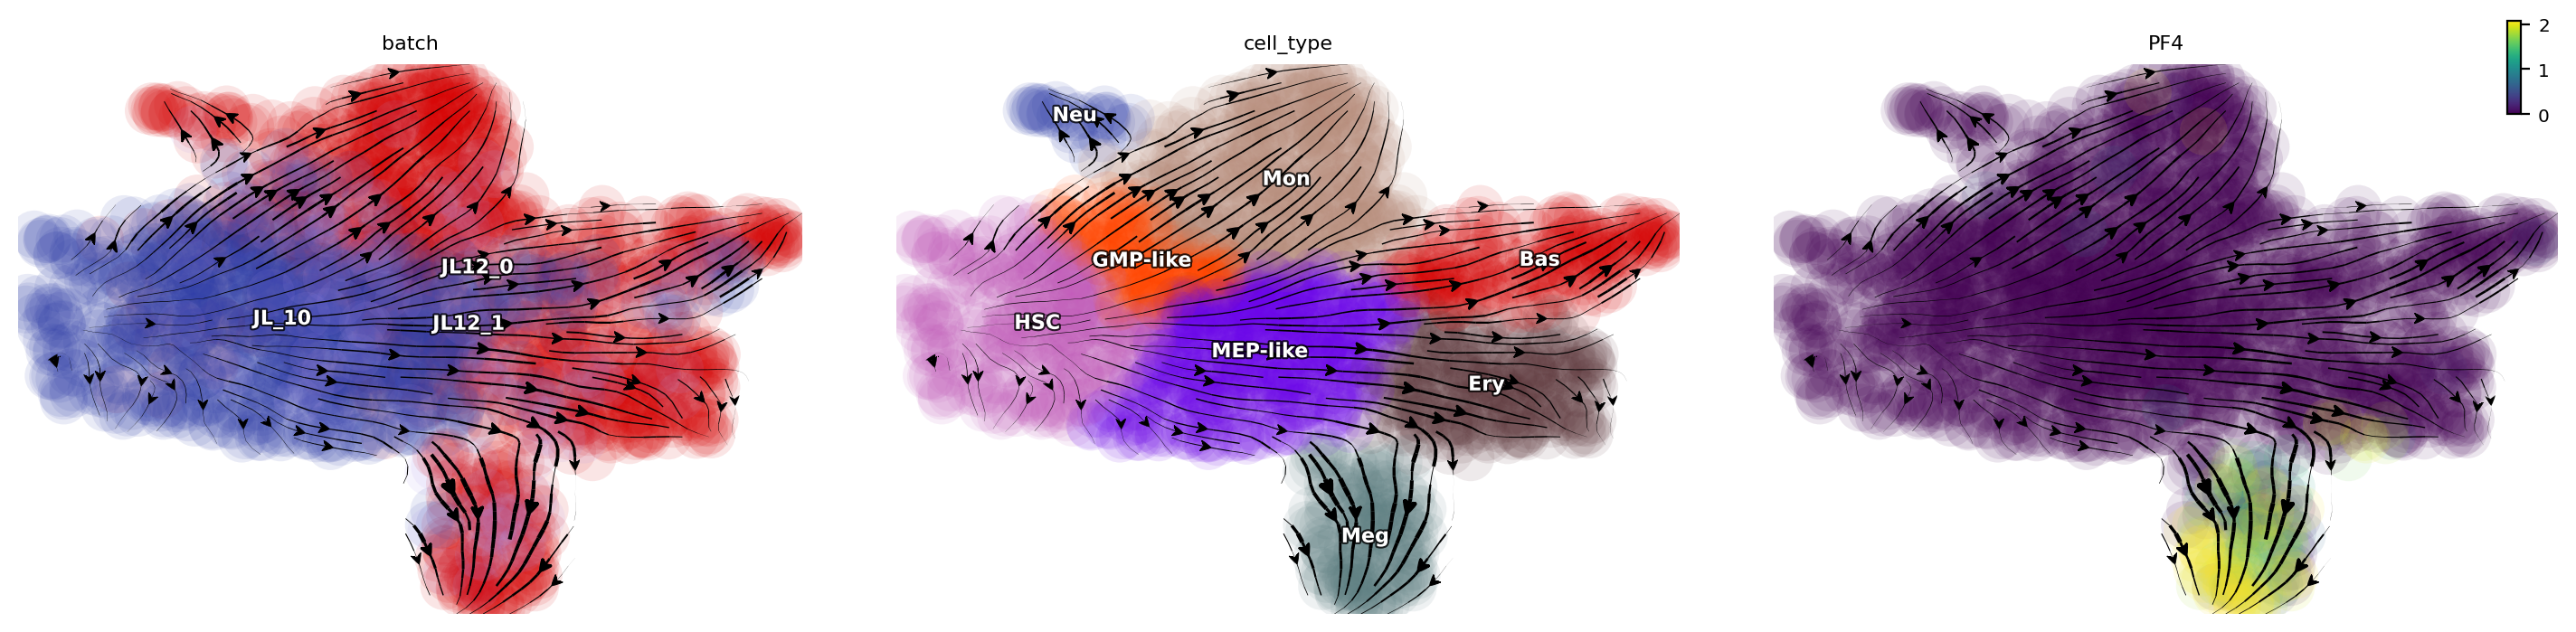

In [ ]:
dyn.pl.streamline_plot(
    adata_hsc_raw,
    color=["batch", "cell_type", "PF4"],
    ncols=4,
    basis="umap",
)

Here we can also visualize the total RNA phase diagram in Figure 3E using dynamo with default settings